In [53]:
import matplotlib.pyplot as plt
import numpy as np
import time

In [72]:
# Gauss-Seidel iterative solution of Ax=b
def gauss_seidel(A, b, x, tolerance=1e-10, max_iterations=10000):
    iter1 = 0
    for k in range(max_iterations):
        iter1 += 1   
        x_old  = x.copy()
        #Loop over rows
        for i in range(A.shape[0]):
            x[i] = (b[i] - np.dot(A[i,:i], x[:i]) - np.dot(A[i,(i+1):], x_old[(i+1):])) / A[i ,i]
        #Stop condition 
        if  max(abs((x - x_old)))/max(abs(x_old)) < tolerance:
            break
    print("The L infinity norm in iteration", iter1,"is:", max(abs((x - x_old)))/max(abs(x_old)))       
    return x

# solve the linear system Ax=b
def solve_linear(A, b):
        #return np.linalg.solve(A, b)
        return gauss_seidel(A, b, -b)
        #return np.linalg.pinv(A).dot(b) 

### Poisson Equation

$
\nabla^2 u = \mathbf{f} 
$



In [73]:
# (solve Au=f) Obs.: The matrix A for poisson with pure Neumann boundary conditions is singular. To solve make "sum f = 0".
# For this case (pure Neumann) there are infinite solution (different constants). 

class Poisson: 
    """
    Finite difference solution of the Poisson equation (elliptic equation)

    Parameters
    ----------
    dx: float
        Block size in meters
    N: int
        Number of blocks
    source_term: list (or numpy array) of floats
        Source term (one value per block -> size N)
    boundary_type: list (or numpy array) of str | default ['Dirichlet','Dirichlet']
        Left and right boundary condition type (options: 'Dirichlet' or 'Neumann'), e.g. ['Dirichlet','Neumann']    
    boundary_values: list (or numpy array) of floats | default [0., 0.]    
        Left and right boundary condition values, e.g. [10., -1.]
    
    Methods
    -------
    forward()
        Solve the Possion equation (Au=f)

    """    
    def __init__(self, dx, N, source_term, boundary_type = ['Dirichlet','Dirichlet'], boundary_values = [0., 0.]):     
        self.dx = dx 
        self.N = N  
        self.source_term = source_term
        self.A = []
        self.f = []
        self.calculated_A_f = False
        self.boundary_type = boundary_type
        self.boundary_values = boundary_values
        self.applied_boundary = False
        
    def calc_A_f_no_boundary(self):
        if self.calculated_A_f:
            print('A and f already calculated!')
        else:
            self.A  = np.diag([-2/(self.dx*self.dx)]*self.N,    0)  # Main diagonal
            self.A += np.diag([1/(self.dx*self.dx)]*(self.N-1), 1)  # Upper diagonal
            self.A += np.diag([1/(self.dx*self.dx)]*(self.N-1),-1)  # Lower diagonal    
            self.f = np.array(self.source_term)                     # Source term
            self.calculated_A_f = True
        return self.A, self.f
    
    def apply_boundary_condition(self):
        if (len(self.f)==0) or (len(self.A)==0):
            print('Matriz A or f not calculeted yet!')
        elif self.applied_boundary:
            print('Boundary already applied!')
        else:
            #Left boundary
            if self.boundary_type[0] == 'Dirichlet':
                self.f[0] += np.array(self.boundary_values[0])/(-self.dx*self.dx)   
            elif self.boundary_type[0] == 'Neumann':
                self.f[0]  += np.array(self.boundary_values[0])/(self.dx)   
                self.A[0,0] += 1/(self.dx*self.dx)
                #self.f -= self.f.mean()  # For pure Neumann boundary condition to have a solution
            else:
                raise RuntimeError('Left boundary: no condition satisfaed!')
            #Right boundary
            if self.boundary_type[1] == 'Dirichlet':
                self.f[-1] += np.array(self.boundary_values[-1])/(-self.dx*self.dx) 
            elif self.boundary_type[1] == 'Neumann':
                self.f[-1] += np.array(self.boundary_values[-1])/(-self.dx)  
                self.A[-1,-1] += 1/(self.dx*self.dx)
                #self.f -= self.f.mean()  # For pure Neumann boundary condition to have a solution
            else:
                raise RuntimeError('Right boundary: no condition satisfaed!')
            self.applied_boundary = True
        return self.A, self.f    
    
    def forward(self):
        """
        Solve the Poisson equation (Au=f)
        
        Returns
        ----------
        u: numpy array of floats
            resulted field (one value per block -> size N)

        """  
        self.calc_A_f_no_boundary()
        self.apply_boundary_condition()   
        return solve_linear(self.A, self.f)
        
        

In [74]:
poisson = Poisson(dx=0.1,
                  N=11,
                  source_term=4*[0.]+3*[-10.]+4*[0.], 
                  boundary_type = ['Dirichlet','Neumann'], 
                  #boundary_type = ['Dirichlet','Dirichlet'], 
                  #boundary_type = ['Neumann','Neumann'], 
                  boundary_values = [1, -1])

The L infinity norm in iteration 874 is: 9.886208292540125e-11
Runtime: 0.04781150817871094


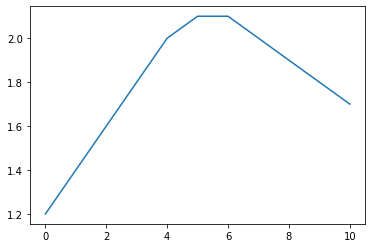

In [75]:
start = time.time()
u = poisson.forward()
print('Runtime:',time.time()-start)
plt.plot(u)

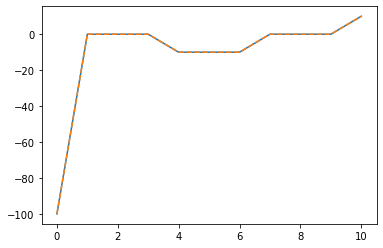

In [39]:
plt.plot(poisson.f)
plt.plot(poisson.A.dot(u),'--')

In [40]:
np.max(abs(poisson.A.dot(u)-poisson.f))

2.0761035557370633e-08

In [41]:
np.linalg.det(poisson.A)

-9.999999999999958e+21

In [42]:
print(poisson.f)

[-100.    0.    0.    0.  -10.  -10.  -10.    0.    0.    0.   10.]


In [43]:
print(poisson.A)

[[-200.  100.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [ 100. -200.  100.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.  100. -200.  100.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.  100. -200.  100.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.  100. -200.  100.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.  100. -200.  100.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.  100. -200.  100.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.  100. -200.  100.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.  100. -200.  100.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.  100. -200.  100.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.  100. -100.]]
